In [1]:
%matplotlib inline

In [2]:
import os
import re
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mripy.xrfunc.io import load_nii
np.set_printoptions(5)

In [3]:
import nibabel as nib

In [4]:
from scipy.optimize import least_squares

In [5]:
te_mop = np.array([ 8.12, 13.19, 19.26, 24.33, 29.4 ]) * 1e-3 # s
# te_bip = np.array([ 7.38, 9.84, 12.3 , 14.76, 17.22, 19.68, 22.14, 24.6, 27.06, 29.52, 31.98, 34.44]) * 1e-3 # s

In [6]:
project_folder = '/data/projects/swi-ms-coop-graz-dfg'
data_folder = os.path.join(project_folder,'data/subjs_all')
media_folder = os.path.join(project_folder,'media/analysis_november')

In [7]:
subject = 'jen-0010980371-20180525'
subject_folder = os.path.join(data_folder,subject)
print(f'Working with {subject}')

Working with jen-0010980371-20180525


In [8]:
mask_path = os.path.join(subject_folder, 'mri/msg_t1w/mege_t1w_brain_mask.nii.gz')
mask = load_nii(mask_path, coords_to_ras=True).astype(bool)
mask_img = nib.load(mask_path)

TypeError: load_nii() got an unexpected keyword argument 'coords_to_ras'

In [ ]:
from skimage import morphology
mask.data = morphology.binary_erosion(mask.data, morphology.ball(3))

# Monopolar

In [ ]:
magn_path = os.path.join(subject_folder, 'mri/msg_pdw/mege_pdw_m_registered.nii.gz')
magn = load_nii(magn_path, coords={'echo': te_mop}, coords_to_ras=False)
magn.name = 'magn'

In [41]:
if mask.ndim != 4:
    mask,_ = xr.broadcast(mask, magn)
magn.data[~mask.data] = np.nan

In [42]:
def nonlinear_fit(da, model, p0, dim_fit='echo', p_bound=([0, 0], [np.inf, np.inf])):
    
    def resid(p, x, y):
        return model(p, x) - y

    df = da.to_dataframe().dropna()
    dim_intact = [d for d in da.dims if d!=dim_fit]
    df_grouped = df.groupby(dim_intact)
    
    # Prepare the closure to fit
    x = da.coords[dim_fit].data
    def fun(y):
        return least_squares(resid, p0, loss='soft_l1', f_scale=0.1,
                             args=(x, y), bounds=p_bound)
    # The fit itself
    df_fit = df_grouped[da.name].apply(fun).to_frame()
    
    return df_fit

def nonlinear_nonnegative_r2_star_fit(da, p0=[500,50]):
    def model(p, t):
        return p[0] * np.exp(-p[1] * t)

    df_fit = nonlinear_fit(da, model, p0, dim_fit='echo', p_bound=([0, 0], [np.inf, np.inf]))

    # Prepare the output
    df_fit.index.set_names(level=-1, names='fit', inplace=True)
    df_res = df_fit.xs('x', level=-1)
    df_res.loc[:,'r2_star'] = [x[1] for x in df_res[da.name].values]
    df_res.loc[:,'s0'] = [x[0] for x in df_res[da.name].values]
    df_res.drop(columns=da.name,inplace=True)
    df_res = df_res.assign(success=df_fit.xs('success', level=-1))
    
    return df_res.to_xarray()

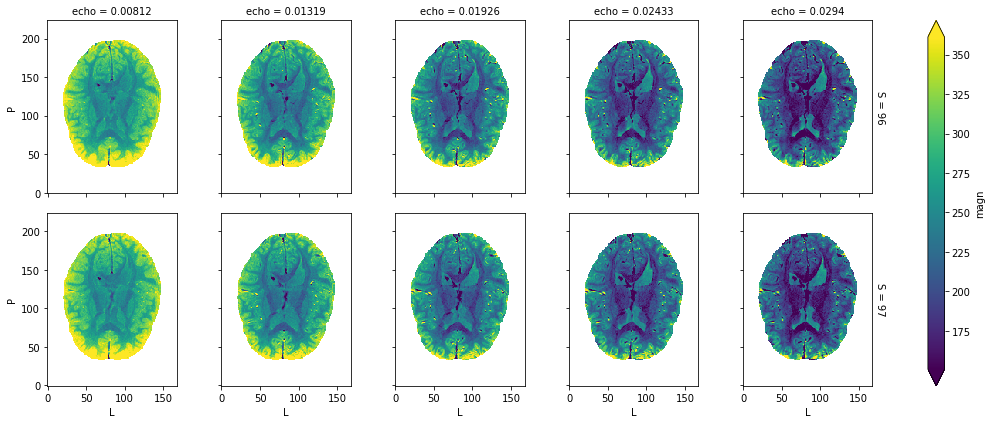

In [44]:
magn.sel(S=[96,97]).plot(x='L', y='P', col='echo', row='S', subplot_kws={'aspect':1}, robust=True)

In [ ]:
ds_res = nonlinear_nonnegative_r2_star_fit(magn)

In [36]:
ds_res

<xarray.Dataset>
Dimensions:  (A: 166, R: 127, S: 128)
Coordinates:
  * R        (R) int64 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 ...
  * A        (A) int64 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 ...
  * S        (S) int64 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 ...
Data variables:
    r2_star  (R, A, S) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    s0       (R, A, S) float64 nan nan nan nan nan nan nan nan nan nan nan ...
    success  (R, A, S) object nan nan nan nan nan nan nan nan nan nan nan ...

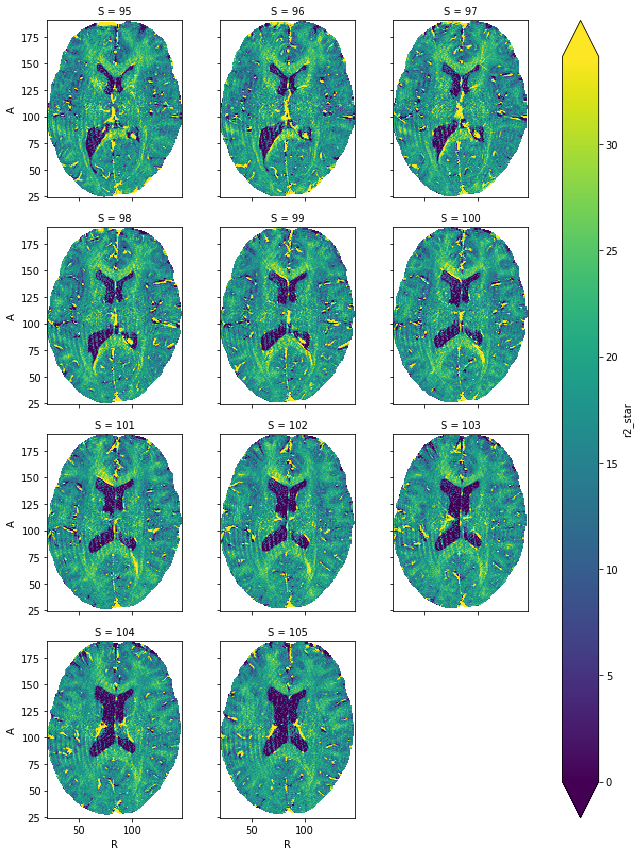

In [35]:
ds_res.r2_star.sel(S=slice(95,105)).plot(x='R', y='A', col='S', col_wrap=3,subplot_kws={'aspect':1}, robust=True)

In [22]:
ds_fit,_ = xr.align(ds_res, mask, join='outer')

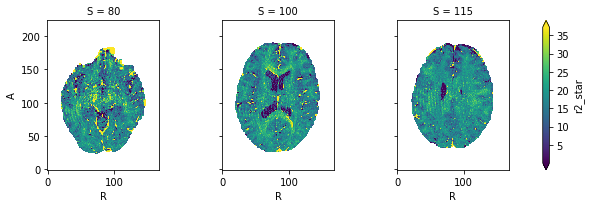

In [23]:
ds_fit.r2_star.sel(S=[80,100,115]).plot(x='R', y='A', col='S', subplot_kws={'aspect':1}, robust=True)

In [24]:
ds_fit.to_netcdf(os.path.join(subject_folder, 'relaxation_r2/nnnl_fit.nc'))

/opt/medphys/miniconda2/envs/py3/lib/python3.6/site-packages/dask/utils.py:1021: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


In [ ]:
# ds_res.r2_star.plot(x='R', y='A', col='S', subplot_kws={'aspect':1}, robust=True)

# ds_res.s0.plot(x='R', y='A', col='S', subplot_kws={'aspect':1}, robust=True)

# ds_res.success.astype(float).plot(x='R', y='A', col='S', subplot_kws={'aspect':1})

# Looping aver files

In [38]:
mask_img = nib.load(mask_path)
r2_star_img = nib.Nifti1Image(ds_fit.r2_star.data, mask_img.affine, mask_img.header)
r2_star_img.to_filename(os.path.join(subject_folder, 'relaxation_r2/r2_star_pdw_nnnl.nii.gz'))